In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json

from pandas.plotting import scatter_matrix
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

# What are the bpps files 
## These are base pairing probability matrix of every possible base pair. 107 X 107 symmetric matrices, where 107 is the number of bases in a RNA sequence

Ingesting the test dataset which is in json format, then bringing it in pandas dataframe

In [2]:
pd.set_option('display.max_colwidth', None)
json_data = [json.loads(line) for line in open('/kaggle/input/stanford-covid-vaccine/test.json', 'r')]
test_df = pd.DataFrame(json_data)
print(test_df.shape)

(3634, 7)


Ingesting the training dataset which is in json format, then bringing it in pandas dataframe

In [3]:
pd.set_option('display.max_colwidth', None)
json_data = [json.loads(line) for line in open('/kaggle/input/stanford-covid-vaccine/train.json', 'r')]
train_df = pd.DataFrame(json_data)
print(train_df.shape)

(2400, 19)


# Bringing the bpps data of every sample

## Vectorized method, without creating another dataframe, thereby saving memory

In [4]:
def get_bpps(row):
    file_location = "".join(['/kaggle/input/stanford-covid-vaccine/bpps/',row['id'],'.npy'])
    bpps_data = np.load(file_location)
    bpps_data_list = list(bpps_data)
    bpps_data_list_68 = bpps_data_list[0:68]
    bpps_data_list_68_68 = []
    for j in range(len(bpps_data_list_68)):
        bpps_data_list_68_68.append(bpps_data_list_68[j][0:68])
        
    row['bpps'] = bpps_data_list_68_68
    return row['bpps']

train_df['bpps'] = train_df.apply(get_bpps, axis=1)
test_df['bpps'] = test_df.apply(get_bpps, axis=1)
## Verifications
print(train_df.shape)
print(test_df.shape)


(2400, 20)
(3634, 8)


In [5]:
"""print(len(train_df['sequence'][100]))
print(len(train_df['deg_50C']))
print(len(train_df['deg_error_50C'][4]))"""

print(len(train_df['bpps']))
print(len(train_df['bpps'][2399]))
print(len(train_df['bpps'][2399][60]))

print(len(test_df['bpps']))
print(len(test_df['bpps'][2399]))
print(len(test_df['bpps'][2399][60]))

"""print(len(train_df['deg_error_Mg_50C'][1]))
print((train_df['reactivity'][1]))
print((train_df['sequence'][1]))
print((train_df['structure'][1]))"""

2400
68
68
3634
68
68


"print(len(train_df['deg_error_Mg_50C'][1]))\nprint((train_df['reactivity'][1]))\nprint((train_df['sequence'][1]))\nprint((train_df['structure'][1]))"

## Dropping unnecessary columns 

In [6]:
training_columns_to_drop = ['signal_to_noise', 'SN_filter', 'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C']
train_df.drop(training_columns_to_drop, axis=1, inplace=True)

test_columns_to_drop = ['seq_length', 'seq_scored']
test_df.drop(test_columns_to_drop, axis=1, inplace=True)

## Breaking down each ID into 68 IDs, one for each RNA base (68 out of the 107 are under modelling scope)
### List based approach, takes way much shorter time than the brute force method

In [7]:
train_colms = ['id_base', 'sequence', 'structure', 'predicted_loop_type', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C', 'bpps']

test_colms = ['id_base', 'sequence', 'structure', 'predicted_loop_type', 'bpps']

def create_rows_per_base(col_name, df):
    col_list = []
    for i in range(df.shape[0]):
        if col_name == 'id_base':
            s = df['id'][i]
            for j in range(68):
                col_list.append("_".join([s, str(j)]))
        else:
            for j in range(68):
                col_list.append(df[col_name][i][j])
            
    return col_list

d_train = {}
for colum in train_colms:
    d_train[colum] = create_rows_per_base(colum, train_df)
    
d_test = {}
for colum in test_colms:
    d_test[colum] = create_rows_per_base(colum, test_df)

seqn_train_df = pd.DataFrame(d_train, columns=train_colms)
seqn_train_df['paired_or_unpaired'] = seqn_train_df['structure'].apply(lambda x: 1 if x == '(' else 1 if x == ')' else 0)
print(seqn_train_df.shape)

seqn_test_df = pd.DataFrame(d_test, columns=test_colms)
seqn_test_df['paired_or_unpaired'] = seqn_test_df['structure'].apply(lambda x: 1 if x == '(' else 1 if x == ')' else 0)
print(seqn_test_df.shape)

(163200, 11)
(247112, 6)


# Creating 68 BPPS columns per base

In [8]:
def add_bpps_per_base(s,j):
    return s[j]

vect_func = np.vectorize(add_bpps_per_base, excluded=['j'])

for jj in range(68):
    seqn_train_df["_".join(['bpps',str(jj)])] = vect_func(seqn_train_df['bpps'], jj)
    
for jj in range(68):
    seqn_test_df["_".join(['bpps',str(jj)])] = vect_func(seqn_test_df['bpps'], jj)
    
print(seqn_train_df.shape)
print(seqn_test_df.shape)

(163200, 79)
(247112, 74)


## Squaring the numeric columns to avoid the negatives and bring everything onto a similar 2D scale
### Labels are left as-is

In [9]:
seqn_train_df_sqrd = seqn_train_df.drop(['structure','bpps'],axis=1)
seqn_test_df_sqrd = seqn_test_df.drop(['structure','bpps'],axis=1)

train_colms_to_sqr = ['bpps_0', 'bpps_1', 'bpps_2', 'bpps_3', 'bpps_4', 'bpps_5', 'bpps_6', 'bpps_7', 'bpps_8', 'bpps_9', 'bpps_10',
       'bpps_11', 'bpps_12', 'bpps_13', 'bpps_14', 'bpps_15', 'bpps_16','bpps_17', 'bpps_18', 'bpps_19', 'bpps_20', 'bpps_21', 'bpps_22',
       'bpps_23', 'bpps_24', 'bpps_25', 'bpps_26', 'bpps_27', 'bpps_28','bpps_29', 'bpps_30', 'bpps_31', 'bpps_32', 'bpps_33', 'bpps_34',
       'bpps_35', 'bpps_36', 'bpps_37', 'bpps_38', 'bpps_39', 'bpps_40','bpps_41', 'bpps_42', 'bpps_43', 'bpps_44', 'bpps_45', 'bpps_46',
       'bpps_47', 'bpps_48', 'bpps_49', 'bpps_50', 'bpps_51', 'bpps_52','bpps_53', 'bpps_54', 'bpps_55', 'bpps_56', 'bpps_57', 'bpps_58',
       'bpps_59', 'bpps_60', 'bpps_61', 'bpps_62', 'bpps_63', 'bpps_64','bpps_65', 'bpps_66', 'bpps_67']

test_colms_to_sqr = ['bpps_0', 'bpps_1', 'bpps_2', 'bpps_3', 'bpps_4', 'bpps_5', 'bpps_6', 'bpps_7', 'bpps_8', 'bpps_9', 'bpps_10',
       'bpps_11', 'bpps_12', 'bpps_13', 'bpps_14', 'bpps_15', 'bpps_16','bpps_17', 'bpps_18', 'bpps_19', 'bpps_20', 'bpps_21', 'bpps_22',
       'bpps_23', 'bpps_24', 'bpps_25', 'bpps_26', 'bpps_27', 'bpps_28','bpps_29', 'bpps_30', 'bpps_31', 'bpps_32', 'bpps_33', 'bpps_34',
       'bpps_35', 'bpps_36', 'bpps_37', 'bpps_38', 'bpps_39', 'bpps_40','bpps_41', 'bpps_42', 'bpps_43', 'bpps_44', 'bpps_45', 'bpps_46',
       'bpps_47', 'bpps_48', 'bpps_49', 'bpps_50', 'bpps_51', 'bpps_52','bpps_53', 'bpps_54', 'bpps_55', 'bpps_56', 'bpps_57', 'bpps_58',
       'bpps_59', 'bpps_60', 'bpps_61', 'bpps_62', 'bpps_63', 'bpps_64','bpps_65', 'bpps_66', 'bpps_67']

for i in range(len(train_colms_to_sqr)):
    col_name = train_colms_to_sqr[i]
    sqrd_col_name = "_".join([col_name,'sqrd'])
    seqn_train_df_sqrd[sqrd_col_name] = np.square(seqn_train_df_sqrd[col_name])

for i in range(len(test_colms_to_sqr)):
    col_name = test_colms_to_sqr[i]
    sqrd_col_name = "_".join([col_name,'sqrd'])
    seqn_test_df_sqrd[sqrd_col_name] = np.square(seqn_test_df_sqrd[col_name])    

seqn_train_df_sqrd.drop(train_colms_to_sqr, axis=1, inplace=True)
print(seqn_train_df_sqrd.shape)

seqn_test_df_sqrd.drop(test_colms_to_sqr, axis=1, inplace=True)
print(seqn_test_df_sqrd.shape)

(163200, 77)
(247112, 72)


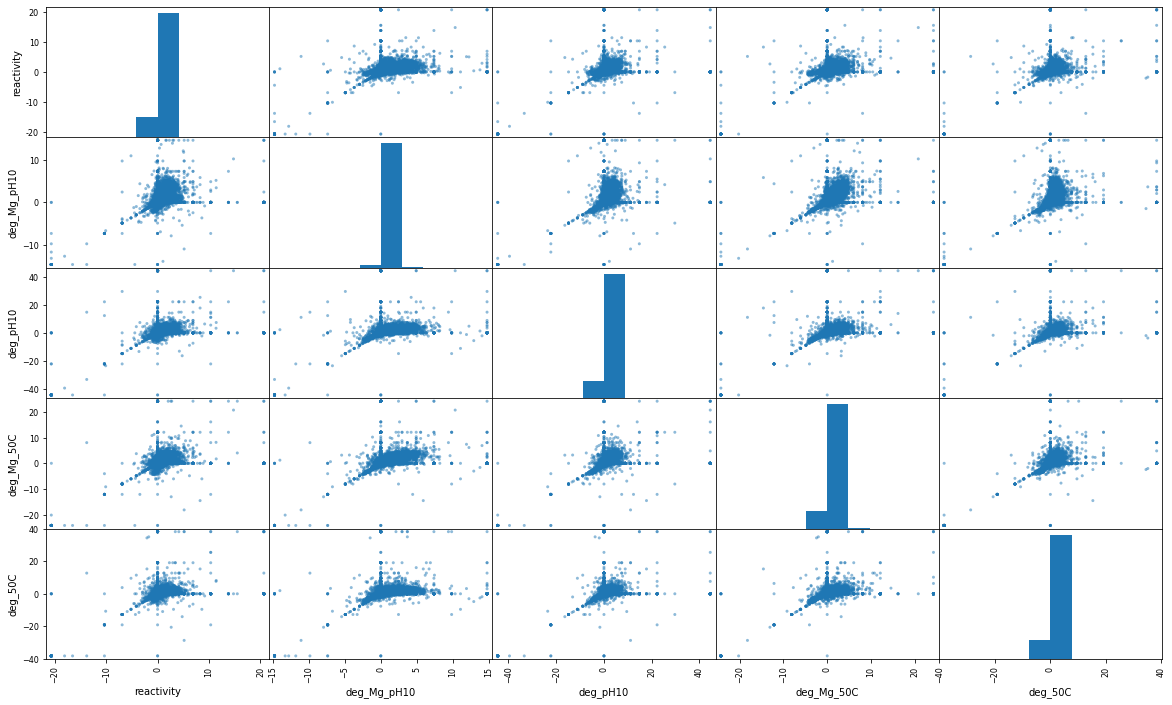

In [10]:
attributes = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

scatter_plot_arr = scatter_matrix(seqn_train_df_sqrd[attributes], figsize=(20,12))

<AxesSubplot:xlabel='deg_pH10', ylabel='deg_Mg_pH10'>

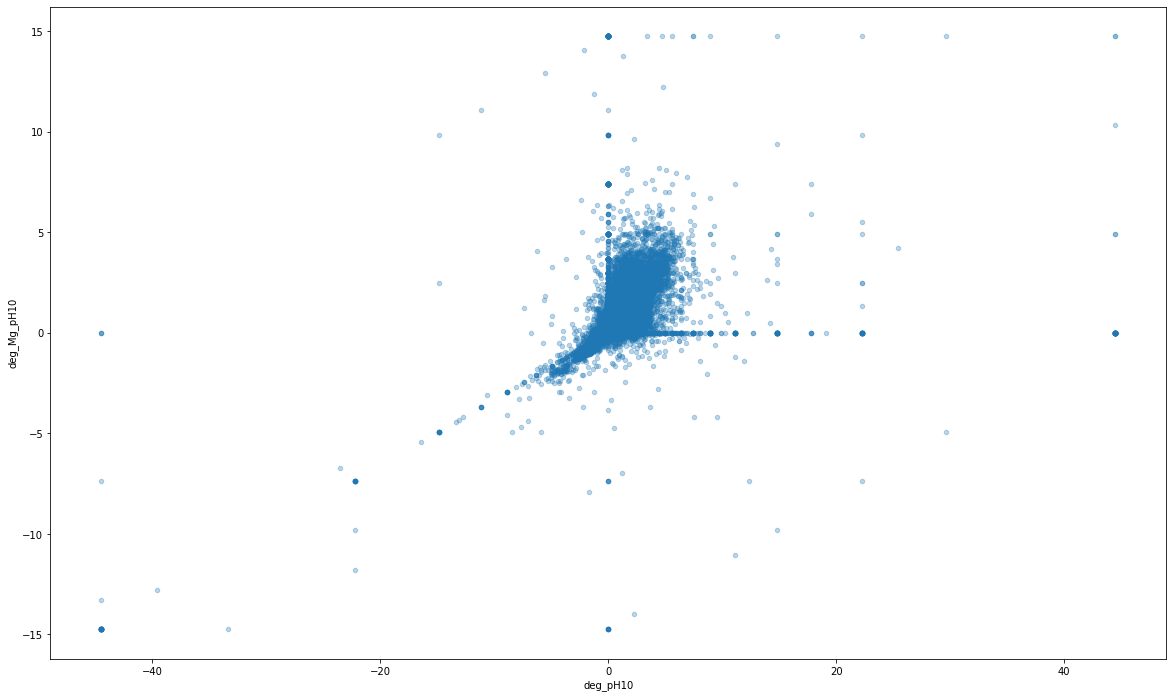

In [11]:
seqn_train_df_sqrd.plot(kind="scatter", x="deg_pH10", y="deg_Mg_pH10", alpha=0.3, figsize=(20,12))

### Observing a polynomial relationship which has quite a few outliers, applying standardization (subtract by mean then divide by standard deviation) to reduce those.
### Using standardization to reduce the effect of outliers in feature scaling

In [12]:
train_colms_for_std = [
       'bpps_0_sqrd', 'bpps_1_sqrd',
       'bpps_2_sqrd', 'bpps_3_sqrd', 'bpps_4_sqrd', 'bpps_5_sqrd',
       'bpps_6_sqrd', 'bpps_7_sqrd', 'bpps_8_sqrd', 'bpps_9_sqrd',
       'bpps_10_sqrd', 'bpps_11_sqrd', 'bpps_12_sqrd', 'bpps_13_sqrd',
       'bpps_14_sqrd', 'bpps_15_sqrd', 'bpps_16_sqrd', 'bpps_17_sqrd',
       'bpps_18_sqrd', 'bpps_19_sqrd', 'bpps_20_sqrd', 'bpps_21_sqrd',
       'bpps_22_sqrd', 'bpps_23_sqrd', 'bpps_24_sqrd', 'bpps_25_sqrd',
       'bpps_26_sqrd', 'bpps_27_sqrd', 'bpps_28_sqrd', 'bpps_29_sqrd',
       'bpps_30_sqrd', 'bpps_31_sqrd', 'bpps_32_sqrd', 'bpps_33_sqrd',
       'bpps_34_sqrd', 'bpps_35_sqrd', 'bpps_36_sqrd', 'bpps_37_sqrd',
       'bpps_38_sqrd', 'bpps_39_sqrd', 'bpps_40_sqrd', 'bpps_41_sqrd',
       'bpps_42_sqrd', 'bpps_43_sqrd', 'bpps_44_sqrd', 'bpps_45_sqrd',
       'bpps_46_sqrd', 'bpps_47_sqrd', 'bpps_48_sqrd', 'bpps_49_sqrd',
       'bpps_50_sqrd', 'bpps_51_sqrd', 'bpps_52_sqrd', 'bpps_53_sqrd',
       'bpps_54_sqrd', 'bpps_55_sqrd', 'bpps_56_sqrd', 'bpps_57_sqrd',
       'bpps_58_sqrd', 'bpps_59_sqrd', 'bpps_60_sqrd', 'bpps_61_sqrd',
       'bpps_62_sqrd', 'bpps_63_sqrd', 'bpps_64_sqrd', 'bpps_65_sqrd',
       'bpps_66_sqrd', 'bpps_67_sqrd'
]

test_colms_for_std = [
       'bpps_0_sqrd', 'bpps_1_sqrd',
       'bpps_2_sqrd', 'bpps_3_sqrd', 'bpps_4_sqrd', 'bpps_5_sqrd',
       'bpps_6_sqrd', 'bpps_7_sqrd', 'bpps_8_sqrd', 'bpps_9_sqrd',
       'bpps_10_sqrd', 'bpps_11_sqrd', 'bpps_12_sqrd', 'bpps_13_sqrd',
       'bpps_14_sqrd', 'bpps_15_sqrd', 'bpps_16_sqrd', 'bpps_17_sqrd',
       'bpps_18_sqrd', 'bpps_19_sqrd', 'bpps_20_sqrd', 'bpps_21_sqrd',
       'bpps_22_sqrd', 'bpps_23_sqrd', 'bpps_24_sqrd', 'bpps_25_sqrd',
       'bpps_26_sqrd', 'bpps_27_sqrd', 'bpps_28_sqrd', 'bpps_29_sqrd',
       'bpps_30_sqrd', 'bpps_31_sqrd', 'bpps_32_sqrd', 'bpps_33_sqrd',
       'bpps_34_sqrd', 'bpps_35_sqrd', 'bpps_36_sqrd', 'bpps_37_sqrd',
       'bpps_38_sqrd', 'bpps_39_sqrd', 'bpps_40_sqrd', 'bpps_41_sqrd',
       'bpps_42_sqrd', 'bpps_43_sqrd', 'bpps_44_sqrd', 'bpps_45_sqrd',
       'bpps_46_sqrd', 'bpps_47_sqrd', 'bpps_48_sqrd', 'bpps_49_sqrd',
       'bpps_50_sqrd', 'bpps_51_sqrd', 'bpps_52_sqrd', 'bpps_53_sqrd',
       'bpps_54_sqrd', 'bpps_55_sqrd', 'bpps_56_sqrd', 'bpps_57_sqrd',
       'bpps_58_sqrd', 'bpps_59_sqrd', 'bpps_60_sqrd', 'bpps_61_sqrd',
       'bpps_62_sqrd', 'bpps_63_sqrd', 'bpps_64_sqrd', 'bpps_65_sqrd',
       'bpps_66_sqrd', 'bpps_67_sqrd'
]

for i in range(len(train_colms_for_std)):
    col_name = train_colms_for_std[i]
    col_name_std = "_".join([col_name, 'std'])
    seqn_train_df_sqrd[col_name_std] = (seqn_train_df_sqrd[col_name] - seqn_train_df_sqrd[col_name].mean())/seqn_train_df_sqrd[col_name].std()
    
for i in range(len(test_colms_for_std)):
    col_name = test_colms_for_std[i]
    col_name_std = "_".join([col_name, 'std'])
    seqn_test_df_sqrd[col_name_std] = (seqn_test_df_sqrd[col_name] - seqn_test_df_sqrd[col_name].mean())/seqn_test_df_sqrd[col_name].std()

seqn_train_df_sqrd.drop(train_colms_for_std, axis=1, inplace=True)
print(seqn_train_df_sqrd.shape)

seqn_test_df_sqrd.drop(test_colms_for_std, axis=1, inplace=True)
print(seqn_test_df_sqrd.shape)

(163200, 77)
(247112, 72)


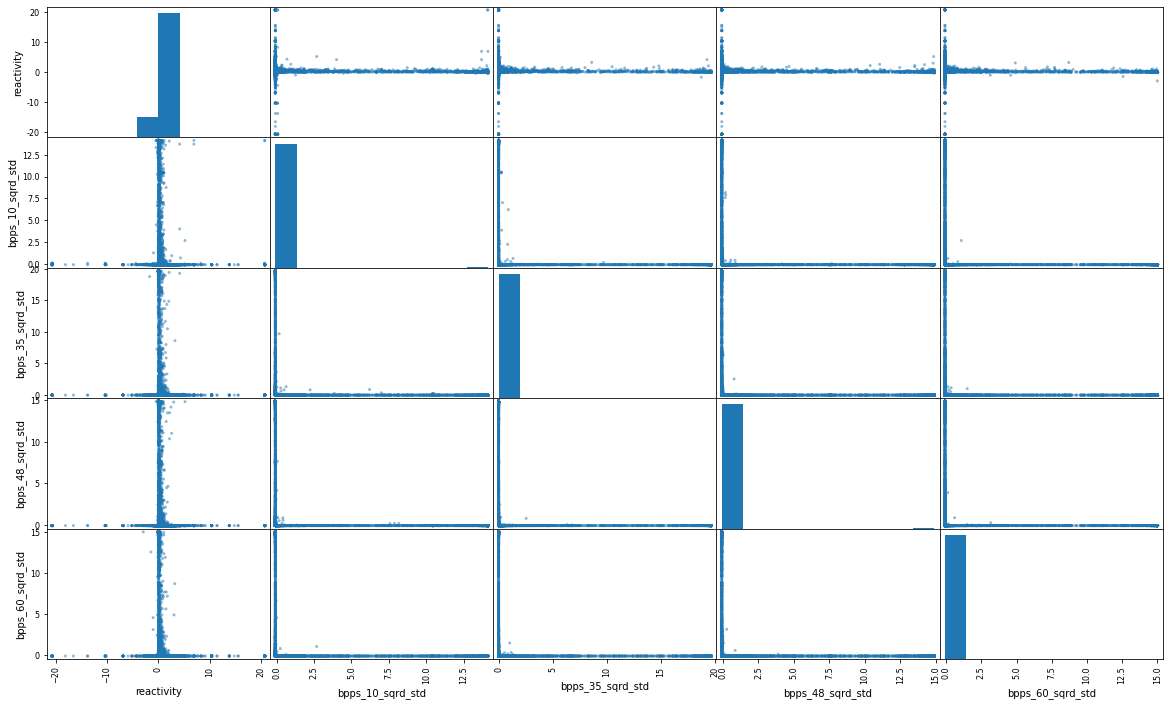

In [13]:
attributes = ['reactivity', 'bpps_10_sqrd_std', 'bpps_35_sqrd_std', 'bpps_48_sqrd_std', 'bpps_60_sqrd_std']

scatter_plot_arr = scatter_matrix(seqn_train_df_sqrd[attributes], figsize=(20,12))

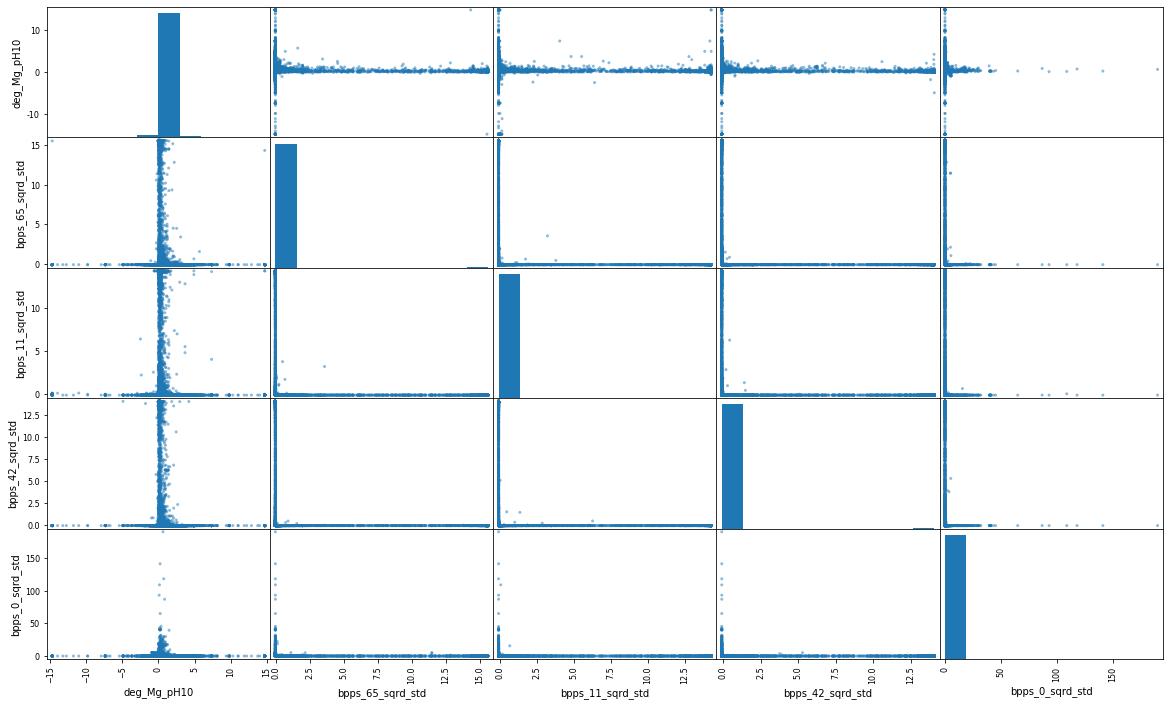

In [14]:
attributes = ['deg_Mg_pH10', 'bpps_65_sqrd_std', 'bpps_11_sqrd_std', 'bpps_42_sqrd_std', 'bpps_0_sqrd_std']

scatter_plot_arr = scatter_matrix(seqn_train_df_sqrd[attributes], figsize=(20,12))

<AxesSubplot:xlabel='bpps_65_sqrd_std', ylabel='deg_Mg_pH10'>

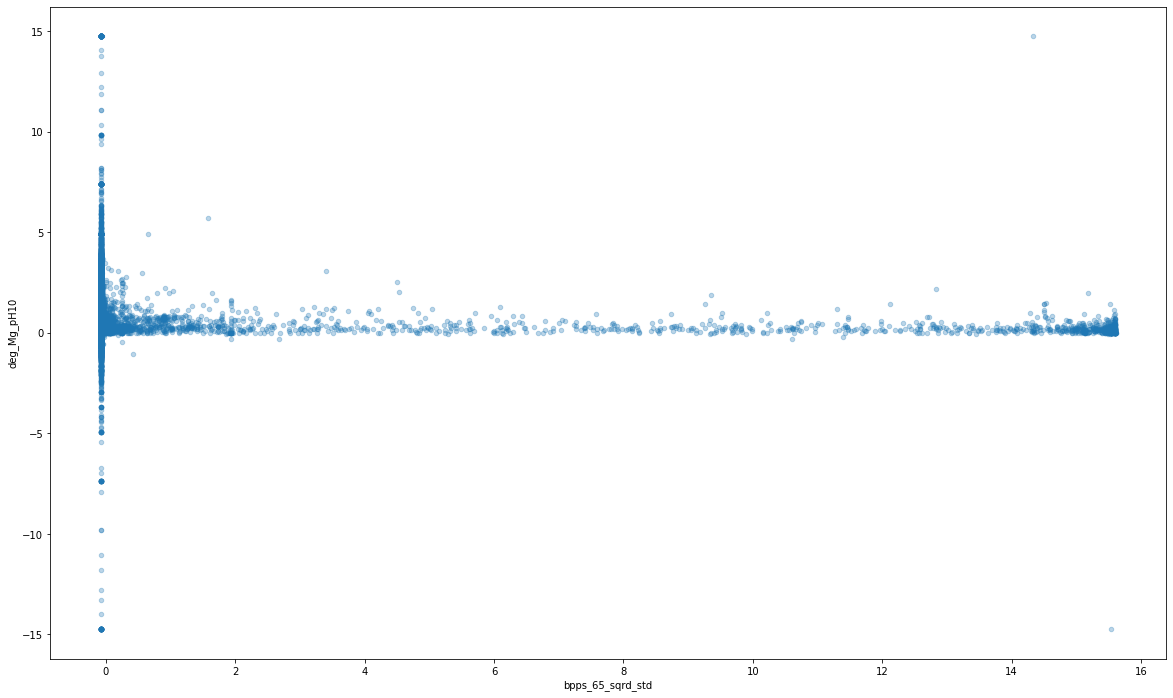

In [15]:
seqn_train_df_sqrd.plot(kind="scatter", x="bpps_65_sqrd_std", y="deg_Mg_pH10", alpha=0.3, figsize=(20,12))

In [16]:
corr_matrix = seqn_train_df_sqrd.corr()
#corr_matrix[['reactivity_sqrd_std', 'deg_Mg_pH10_sqrd_std', 'deg_pH10_sqrd_std', 'deg_Mg_50C_sqrd_std', 'deg_50C_sqrd_std']]
corr_matrix

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,paired_or_unpaired,bpps_0_sqrd_std,bpps_1_sqrd_std,bpps_2_sqrd_std,bpps_3_sqrd_std,...,bpps_58_sqrd_std,bpps_59_sqrd_std,bpps_60_sqrd_std,bpps_61_sqrd_std,bpps_62_sqrd_std,bpps_63_sqrd_std,bpps_64_sqrd_std,bpps_65_sqrd_std,bpps_66_sqrd_std,bpps_67_sqrd_std
reactivity,1.000000,0.462871,0.424549,0.495432,0.452981,-0.264428,-0.005886,-0.010673,-0.004456,-0.001675,...,-0.028372,-0.027590,-0.030677,-0.028928,-0.032443,-0.033275,-0.030590,-0.028046,-0.024626,-0.019568
deg_Mg_pH10,0.462871,1.000000,0.442657,0.560067,0.421421,-0.186309,-0.003376,-0.007380,-0.004898,-0.001704,...,-0.024745,-0.021420,-0.026686,-0.023237,-0.025143,-0.023577,-0.024899,-0.023024,-0.013882,-0.008260
deg_pH10,0.424549,0.442657,1.000000,0.505949,0.471928,-0.133954,0.000530,-0.003395,0.000958,0.002759,...,-0.016460,-0.014673,-0.016870,-0.014360,-0.011779,-0.011191,-0.010352,-0.012059,-0.004177,-0.003887
deg_Mg_50C,0.495432,0.560067,0.505949,1.000000,0.495697,-0.189691,-0.002018,-0.005741,-0.002612,0.000127,...,-0.021093,-0.021152,-0.024855,-0.023132,-0.023612,-0.022051,-0.020019,-0.022040,-0.011958,-0.009622
deg_50C,0.452981,0.421421,0.471928,0.495697,1.000000,-0.134320,0.001437,-0.006263,-0.003621,-0.001844,...,-0.017401,-0.015931,-0.014887,-0.016596,-0.017137,-0.015464,-0.013442,-0.015871,-0.007516,-0.006341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bpps_63_sqrd_std,-0.033275,-0.023577,-0.011191,-0.022051,-0.015464,0.082601,-0.001671,-0.001738,-0.001891,-0.001913,...,-0.006410,-0.006419,-0.006342,-0.006159,-0.006851,1.000000,-0.006200,-0.005961,-0.005795,-0.004159
bpps_64_sqrd_std,-0.030590,-0.024899,-0.010352,-0.020019,-0.013442,0.079298,-0.002089,-0.001817,-0.001341,-0.001895,...,-0.006359,-0.006154,-0.006286,-0.006381,-0.006188,-0.006200,1.000000,-0.006088,-0.005094,-0.004405
bpps_65_sqrd_std,-0.028046,-0.023024,-0.012059,-0.022040,-0.015871,0.074168,-0.001085,-0.001111,-0.001714,-0.001782,...,-0.006094,-0.005921,-0.005880,-0.006196,-0.006324,-0.005961,-0.006088,1.000000,-0.005182,-0.003698
bpps_66_sqrd_std,-0.024626,-0.013882,-0.004177,-0.011958,-0.007516,0.066746,-0.000566,-0.001702,-0.001305,-0.001410,...,-0.005491,-0.005421,-0.005372,-0.005601,-0.005481,-0.005795,-0.005094,-0.005182,1.000000,-0.003800


### From above its quite clear that none of the default features available with the data frame have very high linear correlations. However the charts shows non-linear correlations, hence progressing further

### inversing the bpps column entries

In [17]:
train_colms_for_std = []
test_colms_for_std = []

for i in range(68):
    train_colms_for_std.append("_".join(['bpps',str(i),'sqrd_std']))
    test_colms_for_std.append("_".join(['bpps',str(i),'sqrd_std']))

for i in range(len(train_colms_for_std)):
    col_name = train_colms_for_std[i]
    col_name_std = "_".join([col_name, 'inv'])
    seqn_train_df_sqrd[col_name_std] = 1/seqn_train_df_sqrd[col_name]
    
for i in range(len(test_colms_for_std)):
    col_name = test_colms_for_std[i]
    col_name_std = "_".join([col_name, 'inv'])
    seqn_test_df_sqrd[col_name_std] = 1/seqn_test_df_sqrd[col_name]

seqn_train_df_sqrd.drop(train_colms_for_std, axis=1, inplace=True)
print(seqn_train_df_sqrd.shape)

seqn_test_df_sqrd.drop(test_colms_for_std, axis=1, inplace=True)
print(seqn_test_df_sqrd.shape)

(163200, 77)
(247112, 72)


In [18]:
corr_matrix = seqn_train_df_sqrd.corr()
corr_matrix

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,paired_or_unpaired,bpps_0_sqrd_std_inv,bpps_1_sqrd_std_inv,bpps_2_sqrd_std_inv,bpps_3_sqrd_std_inv,...,bpps_58_sqrd_std_inv,bpps_59_sqrd_std_inv,bpps_60_sqrd_std_inv,bpps_61_sqrd_std_inv,bpps_62_sqrd_std_inv,bpps_63_sqrd_std_inv,bpps_64_sqrd_std_inv,bpps_65_sqrd_std_inv,bpps_66_sqrd_std_inv,bpps_67_sqrd_std_inv
reactivity,1.000000,0.462871,0.424549,0.495432,0.452981,-0.264428,-0.001243,0.001394,0.014032,0.000841,...,0.000293,-0.002397,-0.001505,-0.002901,0.000328,-0.003002,-0.001822,-0.002870,-0.000583,0.001024
deg_Mg_pH10,0.462871,1.000000,0.442657,0.560067,0.421421,-0.186309,-0.001449,0.001818,-0.002560,-0.000026,...,0.000367,-0.001928,-0.000309,-0.002325,0.000777,-0.001471,-0.002743,-0.002059,0.000411,0.000913
deg_pH10,0.424549,0.442657,1.000000,0.505949,0.471928,-0.133954,0.000611,-0.002230,-0.000601,0.000540,...,-0.000411,0.000139,0.000116,-0.001686,0.000424,-0.000618,-0.001216,-0.000059,-0.000113,0.000549
deg_Mg_50C,0.495432,0.560067,0.505949,1.000000,0.495697,-0.189691,-0.000478,0.001211,-0.001746,0.001044,...,0.000083,-0.001884,-0.000004,-0.001952,0.000823,0.001101,-0.001757,-0.001065,-0.000511,0.000736
deg_50C,0.452981,0.421421,0.471928,0.495697,1.000000,-0.134320,0.001336,0.001032,-0.001856,-0.000546,...,0.000008,-0.000758,-0.000706,-0.001567,0.000403,0.000407,-0.001566,-0.000742,-0.000786,0.000678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bpps_63_sqrd_std_inv,-0.003002,-0.001471,-0.000618,0.001101,0.000407,0.009030,-0.000129,0.000008,0.000248,-0.000056,...,-0.001053,-0.000906,-0.000035,0.000482,0.000017,1.000000,-0.000024,-0.001071,0.000384,0.003493
bpps_64_sqrd_std_inv,-0.001822,-0.002743,-0.001216,-0.001757,-0.001566,-0.000460,0.000198,0.000032,0.000266,-0.000271,...,-0.000070,0.000061,0.000045,0.000409,0.000047,-0.000024,1.000000,-0.001272,0.000264,0.000091
bpps_65_sqrd_std_inv,-0.002870,-0.002059,-0.000059,-0.001065,-0.000742,0.001429,0.000120,-0.000068,-0.000087,-0.000035,...,-0.000249,-0.000118,0.000021,-0.000093,0.000214,-0.001071,-0.001272,1.000000,-0.001117,-0.001783
bpps_66_sqrd_std_inv,-0.000583,0.000411,-0.000113,-0.000511,-0.000786,0.000580,0.000215,-0.000122,-0.000140,0.000069,...,-0.000013,0.000168,-0.000131,0.000261,0.000053,0.000384,0.000264,-0.001117,1.000000,0.000260


### separating out the features and labels and then will try out some combinations to see if we can improve the correlations

In [19]:
seqn_train_df_sqrd_labels = seqn_train_df_sqrd[['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']]
seqn_train_df_sqrd_features = seqn_train_df_sqrd[['sequence', 'predicted_loop_type', 'paired_or_unpaired',
       'bpps_0_sqrd_std_inv',
'bpps_1_sqrd_std_inv',
'bpps_2_sqrd_std_inv',
'bpps_3_sqrd_std_inv',
'bpps_4_sqrd_std_inv',
'bpps_5_sqrd_std_inv',
'bpps_6_sqrd_std_inv',
'bpps_7_sqrd_std_inv',
'bpps_8_sqrd_std_inv',
'bpps_9_sqrd_std_inv',
'bpps_10_sqrd_std_inv',
'bpps_11_sqrd_std_inv',
'bpps_12_sqrd_std_inv',
'bpps_13_sqrd_std_inv',
'bpps_14_sqrd_std_inv',
'bpps_15_sqrd_std_inv',
'bpps_16_sqrd_std_inv',
'bpps_17_sqrd_std_inv',
'bpps_18_sqrd_std_inv',
'bpps_19_sqrd_std_inv',
'bpps_20_sqrd_std_inv',
'bpps_21_sqrd_std_inv',
'bpps_22_sqrd_std_inv',
'bpps_23_sqrd_std_inv',
'bpps_24_sqrd_std_inv',
'bpps_25_sqrd_std_inv',
'bpps_26_sqrd_std_inv',
'bpps_27_sqrd_std_inv',
'bpps_28_sqrd_std_inv',
'bpps_29_sqrd_std_inv',
'bpps_30_sqrd_std_inv',
'bpps_31_sqrd_std_inv',
'bpps_32_sqrd_std_inv',
'bpps_33_sqrd_std_inv',
'bpps_34_sqrd_std_inv',
'bpps_35_sqrd_std_inv',
'bpps_36_sqrd_std_inv',
'bpps_37_sqrd_std_inv',
'bpps_38_sqrd_std_inv',
'bpps_39_sqrd_std_inv',
'bpps_40_sqrd_std_inv',
'bpps_41_sqrd_std_inv',
'bpps_42_sqrd_std_inv',
'bpps_43_sqrd_std_inv',
'bpps_44_sqrd_std_inv',
'bpps_45_sqrd_std_inv',
'bpps_46_sqrd_std_inv',
'bpps_47_sqrd_std_inv',
'bpps_48_sqrd_std_inv',
'bpps_49_sqrd_std_inv',
'bpps_50_sqrd_std_inv',
'bpps_51_sqrd_std_inv',
'bpps_52_sqrd_std_inv',
'bpps_53_sqrd_std_inv',
'bpps_54_sqrd_std_inv',
'bpps_55_sqrd_std_inv',
'bpps_56_sqrd_std_inv',
'bpps_57_sqrd_std_inv',
'bpps_58_sqrd_std_inv',
'bpps_59_sqrd_std_inv',
'bpps_60_sqrd_std_inv',
'bpps_61_sqrd_std_inv',
'bpps_62_sqrd_std_inv',
'bpps_63_sqrd_std_inv',
'bpps_64_sqrd_std_inv',
'bpps_65_sqrd_std_inv',
'bpps_66_sqrd_std_inv',
'bpps_67_sqrd_std_inv']]

### First lets try building a model using available features as-is

In [20]:
polynomial_pipeline = Pipeline([('poly',PolynomialFeatures(degree=1, include_bias=False))])

categorical_attributes = ['sequence','predicted_loop_type']
numeric_atributes = ['paired_or_unpaired',
       'bpps_0_sqrd_std_inv',
'bpps_1_sqrd_std_inv',
'bpps_2_sqrd_std_inv',
'bpps_3_sqrd_std_inv',
'bpps_4_sqrd_std_inv',
'bpps_5_sqrd_std_inv',
'bpps_6_sqrd_std_inv',
'bpps_7_sqrd_std_inv',
'bpps_8_sqrd_std_inv',
'bpps_9_sqrd_std_inv',
'bpps_10_sqrd_std_inv',
'bpps_11_sqrd_std_inv',
'bpps_12_sqrd_std_inv',
'bpps_13_sqrd_std_inv',
'bpps_14_sqrd_std_inv',
'bpps_15_sqrd_std_inv',
'bpps_16_sqrd_std_inv',
'bpps_17_sqrd_std_inv',
'bpps_18_sqrd_std_inv',
'bpps_19_sqrd_std_inv',
'bpps_20_sqrd_std_inv',
'bpps_21_sqrd_std_inv',
'bpps_22_sqrd_std_inv',
'bpps_23_sqrd_std_inv',
'bpps_24_sqrd_std_inv',
'bpps_25_sqrd_std_inv',
'bpps_26_sqrd_std_inv',
'bpps_27_sqrd_std_inv',
'bpps_28_sqrd_std_inv',
'bpps_29_sqrd_std_inv',
'bpps_30_sqrd_std_inv',
'bpps_31_sqrd_std_inv',
'bpps_32_sqrd_std_inv',
'bpps_33_sqrd_std_inv',
'bpps_34_sqrd_std_inv',
'bpps_35_sqrd_std_inv',
'bpps_36_sqrd_std_inv',
'bpps_37_sqrd_std_inv',
'bpps_38_sqrd_std_inv',
'bpps_39_sqrd_std_inv',
'bpps_40_sqrd_std_inv',
'bpps_41_sqrd_std_inv',
'bpps_42_sqrd_std_inv',
'bpps_43_sqrd_std_inv',
'bpps_44_sqrd_std_inv',
'bpps_45_sqrd_std_inv',
'bpps_46_sqrd_std_inv',
'bpps_47_sqrd_std_inv',
'bpps_48_sqrd_std_inv',
'bpps_49_sqrd_std_inv',
'bpps_50_sqrd_std_inv',
'bpps_51_sqrd_std_inv',
'bpps_52_sqrd_std_inv',
'bpps_53_sqrd_std_inv',
'bpps_54_sqrd_std_inv',
'bpps_55_sqrd_std_inv',
'bpps_56_sqrd_std_inv',
'bpps_57_sqrd_std_inv',
'bpps_58_sqrd_std_inv',
'bpps_59_sqrd_std_inv',
'bpps_60_sqrd_std_inv',
'bpps_61_sqrd_std_inv',
'bpps_62_sqrd_std_inv',
'bpps_63_sqrd_std_inv',
'bpps_64_sqrd_std_inv',
'bpps_65_sqrd_std_inv',
'bpps_66_sqrd_std_inv',
'bpps_67_sqrd_std_inv']

modelling_pipeline = ColumnTransformer([
    ("categorical_attributes", OneHotEncoder(), categorical_attributes),
    ("numeric_atributes", polynomial_pipeline, numeric_atributes)
])

seqn_train_df_prepared = modelling_pipeline.fit_transform(seqn_train_df_sqrd_features)

In [21]:
print(seqn_train_df_prepared.shape)
print(seqn_train_df_sqrd_features.shape)

(163200, 80)
(163200, 71)


In [22]:
from sklearn.linear_model import LinearRegression

poly_reg_model = LinearRegression()
poly_reg_model.fit(seqn_train_df_prepared, seqn_train_df_sqrd_labels)

LinearRegression()

In [23]:
type(poly_reg_model)

sklearn.linear_model._base.LinearRegression

In [24]:
some_data = seqn_train_df_sqrd_features.iloc[:5]
some_labels = seqn_train_df_sqrd_labels.iloc[:5]

some_data_prepared = modelling_pipeline.transform(some_data)

In [25]:
print(some_data_prepared.shape)
print(some_data.shape)

(5, 80)
(5, 71)


In [26]:
pd.DataFrame(poly_reg_model.predict(some_data_prepared),columns=['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C'])

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0.593554,0.704320,1.009436,0.692095,0.708997
1,0.593295,0.703854,1.009288,0.692210,0.708662
2,0.582583,0.541046,0.715901,0.635685,0.645455
3,0.582553,0.541031,0.715856,0.635663,0.645424
4,0.582559,0.541029,0.715862,0.635662,0.645427


In [27]:
some_labels

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0.3297,0.7556,2.3375,0.3581,0.6382
1,1.5693,2.9830,3.5060,2.9683,3.4773
2,1.1227,0.2526,0.3008,0.2589,0.9988
3,0.8686,1.3789,1.0108,1.4552,1.3228
4,0.7217,0.6376,0.2635,0.7244,0.7877


### The above test shows extremely bad predictions which are nowhere near reality

### Testing the RMSE
#### RMSE <= 0.75 : Very good accuracy
#### 0.75 < RMSE <= 1.0 : Good accuracy

### Lets investigate the RMSE

In [28]:
from sklearn.metrics import mean_squared_error

seqn_train_df_predictions = poly_reg_model.predict(seqn_train_df_prepared)
mse = mean_squared_error(seqn_train_df_sqrd_labels, seqn_train_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

0.9489331277435574


### The overall RMSE looks okay, not too good, neither too bad, as expected, since there was poor correlation

In [29]:
seqn_train_df_predictions.shape

(163200, 5)

In [30]:
type(seqn_train_df_predictions)

numpy.ndarray

In [31]:
seqn_train_df_sqrd_labels

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0.3297,0.7556,2.3375,0.3581,0.6382
1,1.5693,2.9830,3.5060,2.9683,3.4773
2,1.1227,0.2526,0.3008,0.2589,0.9988
3,0.8686,1.3789,1.0108,1.4552,1.3228
4,0.7217,0.6376,0.2635,0.7244,0.7877
...,...,...,...,...,...
163195,0.0272,0.5059,0.4998,0.2870,0.1820
163196,0.0382,0.2025,0.3057,0.2022,0.2038
163197,0.0381,0.1827,0.1642,0.2047,0.1120
163198,-0.0066,0.3261,0.1654,0.2447,0.1186


In [32]:
pd.DataFrame(seqn_train_df_predictions[:,0])

,0
0,0.593554
1,0.593295
2,0.582583
3,0.582553
4,0.582559
...,...
163195,0.056176
163196,0.187710
163197,0.239193
163198,0.249044


In [33]:
mse_reactivity_sqrd_std = mean_squared_error(seqn_train_df_sqrd_labels['reactivity'], seqn_train_df_predictions[:,0])
rmse_reactivity_sqrd_std = np.sqrt(mse_reactivity_sqrd_std)
print(rmse_reactivity_sqrd_std)

0.6940016411213807


In [34]:
mse_deg_Mg_pH10_sqrd_std = mean_squared_error(seqn_train_df_sqrd_labels['deg_Mg_pH10'], seqn_train_df_predictions[:,1])
rmse_deg_Mg_pH10_sqrd_std = np.sqrt(mse_deg_Mg_pH10_sqrd_std)
print(rmse_deg_Mg_pH10_sqrd_std)

0.6872464279332461


In [35]:
mse_deg_pH10_sqrd_std = mean_squared_error(seqn_train_df_sqrd_labels['deg_pH10'], seqn_train_df_predictions[:,2])
rmse_deg_pH10_sqrd_std = np.sqrt(mse_deg_pH10_sqrd_std)
print(rmse_deg_pH10_sqrd_std)

1.262967107240722


In [36]:
mse_deg_Mg_50C_sqrd_std = mean_squared_error(seqn_train_df_sqrd_labels['deg_Mg_50C'], seqn_train_df_predictions[:,3])
rmse_deg_Mg_50C_sqrd_std = np.sqrt(mse_deg_Mg_50C_sqrd_std)
print(rmse_deg_Mg_50C_sqrd_std)

0.8493861067793692


In [37]:
mse_deg_50C_sqrd_std = mean_squared_error(seqn_train_df_sqrd_labels['deg_50C'], seqn_train_df_predictions[:,3])
rmse_deg_50C_sqrd_std = np.sqrt(mse_deg_50C_sqrd_std)
print(rmse_deg_50C_sqrd_std)

1.110393465485119


# MCRMSE

In [38]:
(rmse_deg_50C_sqrd_std + rmse_deg_Mg_50C_sqrd_std + rmse_deg_pH10_sqrd_std + rmse_deg_Mg_pH10_sqrd_std + rmse_reactivity_sqrd_std)/5

0.9207989497119675